# Parallel bwtzip speedup analysis  (pbwtzip)

## Introduction

The aim of this notebook is to analyze and evaluate the performance improvements obtained through the parallelization of the bwtzip loseless compression algorithm.

**pbwtzip** is the parallel version of the bwtzip library. It has been developed starting from the sequential original code of bwtzip and then parallelized by the use of OpenMP APIs. Moreover, some changes have been made to the code and internal data structures in order to achieve a good parallelization strategy. 


## Sequential bwtzip

The sequential version of bwtzip can be schematized by **4 functions** that are sequentially applied to a chunk of data to be compressed. A chunk of data is read from the input file and write, after compression, to the output file.


```python
bwtCompress(data_chunk) {
    bwtfxn(data_chunk)      # F1: Burrows–Wheeler transform
    mtf2(data_chunk)        # F2: Move-To-Front (MTF)
    zleWheeler(data_chunk)  # F3: Wheeler Zero Length Encoder
    arith(data_chunk)       # F4: Arithmetic Coding
}

while(data_chunk = file_in.read_chunk()) {
    bwtCompress(data_chunk)
    file_out.append(data_chunk)
}

```


## Parallel bwtzip

To parallelize the functions, since the have execution time very  execution a **pipeline of stages** was created. 

The pipeline has been organized in 3 stages (+1 reader, +1 writer)

#### Functions per stage

<!-- the below schema was imported as image so to avoid line wrapping problems
```
          ________      _________________     _________________      ___________      _______      
         | Reader |    |    Stage 1      |    |     Stage 2    |    |  Stage 3  |    | Writer |        
File ———>|        |———>| F1: Suffix Tree |———>| F2: mtf2       |———>| F4: arith |———>|        |———> File
 in      |        |    |     Sort        |    | F3: zleWheeler |    |           |    |        |      out
          ‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾      
```
-->

![pbwtzip pipeline functions](images/pbwtzip_pipeline_functions.png)

In between each stage, a double-sided buffer is present to let stages write and read without collisions.

#### Pipeline overview

<!-- the below schema was imported as image so to avoid line wrapping problems
```
               bufferR_1      buffer1_2      buffer2_3      buffer3_W            
          ___     ||     ___     ||     ___     ||     ___     ||     ___ 
         |   |    ||    |    |   ||    |    |   ||    |    |   ||    |   |  
File ———>| R |———>||———>| S1 |——>||———>| S2 |——>||———>| S3 |——>||———>| W |——> File
 in      |   |    ||    |    |   ||    |    |   ||    |    |   ||    |   |     out
          ‾‾‾     ||     ‾‾‾     ||     ‾‾‾     ||     ‾‾‾     ||     ‾‾‾  
          
```
-->

![pbwtzip pipeline functions](images/pbwtzip_pipeline_overview.png)

#### Workflow

Buffers are of size **K per side**. Hence K\*2 chunks of data are overall stored in the buffer.

At each pipeline iteration every stage withdraw **K** chunks of data from the buffer preceding it and, after performing the functions assigned, it writes them to the buffer after the stage.
Only exceptions to this are: 
 - Reader: only fill the buffer following it with the chunks read from input file
 - Writer: only read the buffer preceding it and write compressed data chunks to output file

The **k parameter** is defined at runtime based on the thread configuration passed as parameter to pbwtzip.

#### Threads configuration

The threads configuration is the parallelization layout that is used by pbwtzip to assign number of threads to the stages, so to run "multiple instances" of them in parallel over differen chunks of data.

For example, the thread configuration: `5.2.1` would assign

- 5 threads&nbsp;to Stage 1
- 2 threads&nbsp;to Stage 2
- 1 thread&nbsp;&nbsp; to Stage 3


#### K parameter

The k parameter is *automatically set at runtime* to the highest number of threads assigned. For example, by providing a thread configuration like `8.2.1` it will be set to K=`8`. The K parameter, as already said, will be the size of the side of double-sided buffers so to promote the highest parallelism and least collisions as possible.


## Parameters space

Then, the parameters that can be used to change the pbwtzip exectuon performances are:

- chunk size
- thread configuration

The below shown comparison will highlight the speedup optained with the parallel version bwtzip with reespect to its sequential version.


## Speedup computation

**Sequential execution time**

Time required to run the **best sequential algorithm** on one processor&nbsp;&nbsp;&nbsp;&nbsp;$T^*(n)$

**Parallel execution time**

Time required by the parallel algorithm to run on **p processors**&nbsp;&nbsp;&nbsp;$T_p(n)$


## Speedup
Optained speedup on p processors 

$$Speedup = \frac{T^*(n)}{T_p(n)}$$


## Data used for tests

The below reported results were obtained by running this notebook on the files:
```
dataset
  ├── [682K]  sense11.txt
  ├── [1.0M]  1400-0.txt
  ├── [1.9M]  pg1023.txt
  ├── [3.7M]  world02.txt
  ├── [4.7M]  cwgen11.txt
  ├── [9.4M]  suall10.txt
  ├── [ 19M]  mtent13.txt
  └── [ 87M]  01hgp10a.txt
``` 



## Hardware characteristics

The following tests have been run on a
> Macbook Pro 8,3 Early 2011 shipping an Intel(R) Core(TM) i7-2860QM CPU @ 2.50GHz (4 physical cores with 2 logical ones each)
>
> RAM: 8 Gb


#### Warning

In order **to run this notebook properly**, please do compile the project by making sure that the defines at the top of `include/log.hh` are:

```c
#define LOG_SUFFIX_TREE 0
#define LOG_DFS 0
#define LOG_BWTZIP 0
#define LOG_BWTUNZIP 0

#define LOG_PBWTZIP 0
#define LOG_STAGE 0
#define LOG_CHUNKS 0
#define LOG_TEST 0
#define LOG_STATISTICS 0

#define LOG_STATISTICS_CSV 1
```


In [1]:
from utils_execution import get_sequential_compression_times, get_pbwtzip_parallel_compression_times

In [2]:
# in Kb
chunk_sizes = [25, 50, 100, 200, 500, 1024, 1024*5]
# converted in bytes
chunk_sizes = [int(x*1024) for x in chunk_sizes]

thread_confs = ['1.1.1', '2.1.1', '4.1.1', '5.2.1', '6.1.1', '6.2.1', '7.1.1', '8.1.1', '8.2.1', '10.1.1']

In [3]:
# compute sequential compression times according to chunk sizes
sequential_compression_times = get_sequential_compression_times(chunk_sizes)

25600
51200
102400
204800
512000
1048576
5242880
Repetition  0 performed
[33.091671 33.314299 42.09695  53.268314 66.570581 74.77131  91.423102]
25600
51200
102400
204800
512000
1048576
5242880
Repetition  1 performed
[32.571461 33.885223 42.088778 53.199463 66.005323 74.780292 91.628468]
25600
51200
102400
204800
512000
1048576
5242880
Repetition  2 performed
[32.20642  33.876614 41.903638 53.499635 66.021581 74.911425 93.394159]


In [4]:
import numpy as np
np.save('sequential_compression_times', sequential_compression_times)
print(sequential_compression_times)

[32.20642  33.314299 41.903638 53.199463 66.005323 74.77131  91.423102]


In [5]:
print("sequential_compression_times sum")
print(round(sequential_compression_times.sum()/60,2), " minutes")
print("\nTotal actual execution time")
print(round((sequential_compression_times.sum() * 3)/60,2), " minutes")

sequential_compression_times sum
6.55  minutes

Total actual execution time
19.64  minutes


In [6]:
# compute parallel compression times according to chunk sizes and thread conf
parallel_compression_times = get_pbwtzip_parallel_compression_times(chunk_sizes, thread_confs)

1.1.1 25600
2.1.1 25600
4.1.1 25600
5.2.1 25600
6.1.1 25600
6.2.1 25600
7.1.1 25600
8.1.1 25600
8.2.1 25600
10.1.1 25600
1.1.1 51200
2.1.1 51200
4.1.1 51200
5.2.1 51200
6.1.1 51200
6.2.1 51200
7.1.1 51200
8.1.1 51200
8.2.1 51200
10.1.1 51200
1.1.1 102400
2.1.1 102400
4.1.1 102400
5.2.1 102400
6.1.1 102400
6.2.1 102400
7.1.1 102400
8.1.1 102400
8.2.1 102400
10.1.1 102400
1.1.1 204800
2.1.1 204800
4.1.1 204800
5.2.1 204800
6.1.1 204800
6.2.1 204800
7.1.1 204800
8.1.1 204800
8.2.1 204800
10.1.1 204800
1.1.1 512000
2.1.1 512000
4.1.1 512000
5.2.1 512000
6.1.1 512000
6.2.1 512000
7.1.1 512000
8.1.1 512000
8.2.1 512000
10.1.1 512000
1.1.1 1048576
2.1.1 1048576
4.1.1 1048576
5.2.1 1048576
6.1.1 1048576
6.2.1 1048576
7.1.1 1048576
8.1.1 1048576
8.2.1 1048576
10.1.1 1048576
1.1.1 5242880
2.1.1 5242880
4.1.1 5242880
5.2.1 5242880
6.1.1 5242880
6.2.1 5242880
7.1.1 5242880
8.1.1 5242880
8.2.1 5242880
10.1.1 5242880
Repetition  0 performed
[[34.376354 27.85251  18.246323 18.406494 18.006012 18.0359

In [7]:
print(parallel_compression_times)

[[34.157748 27.85251  18.147109 18.092374 17.896745 17.870633 17.424336
  17.374438 17.553518 17.26704 ]
 [36.427204 26.621504 20.140312 19.991459 19.426267 19.220173 18.712633
  18.728025 18.40007  18.674788]
 [43.454798 30.876199 22.675797 22.585761 21.085636 21.015937 19.961576
  20.210704 20.280224 20.871831]
 [52.178205 35.194141 24.802898 24.71334  23.088021 22.641262 21.629854
  22.02402  21.863769 23.206388]
 [64.393922 41.117643 27.951933 28.401199 25.456943 25.774986 24.510307
  24.719569 24.819273 26.860941]
 [73.626648 45.794854 32.776581 30.978669 29.344171 29.260502 28.361504
  28.504757 28.870061 32.004941]
 [92.509649 59.906752 45.748395 43.627726 42.165718 42.662484 40.275964
  41.724084 41.77719  44.006356]]


In [8]:
print("parallel_compression_times sum")
print(round(parallel_compression_times.sum()/60,2), " minutes")
print("\nTotal actual execution time")
print(round((parallel_compression_times.sum() * 3)/60,2), " minutes")

parallel_compression_times sum
35.04  minutes

Total actual execution time
105.11  minutes


In [9]:
# compute speedup
speedup = (sequential_compression_times / parallel_compression_times.T).T

In [10]:
print(speedup)

[[0.94287305 1.1563202  1.77474109 1.78011023 1.79956858 1.80219805
  1.84835853 1.85366686 1.83475586 1.86519635]
 [0.9145445  1.25140559 1.65411037 1.6664266  1.71490997 1.7332986
  1.78031061 1.77884742 1.81055284 1.78391846]
 [0.96430406 1.35715015 1.84794554 1.8553122  1.98730728 1.99389815
  2.09921491 2.07333886 2.06623152 2.00766468]
 [1.0195725  1.51159998 2.144889   2.1526618  2.30420195 2.34966863
  2.4595387  2.4155201  2.43322471 2.29244909]
 [1.02502412 1.60527983 2.36138671 2.32403297 2.59282204 2.56082867
  2.6929619  2.6701648  2.65943821 2.45729749]
 [1.01554684 1.63274481 2.2812419  2.41363856 2.5480805  2.55536662
  2.63636618 2.62311691 2.5899256  2.33624271]
 [0.98825477 1.52609011 1.99838928 2.09552756 2.16818559 2.14293903
  2.26991716 2.19113503 2.18834972 2.07749767]]


## Computations summary

In [11]:
print("Sequential_compression_times\n", sequential_compression_times)
print("\nParallel_compression_times\n", parallel_compression_times)
print("\nSpeedup\n", speedup)

Sequential_compression_times
 [32.20642  33.314299 41.903638 53.199463 66.005323 74.77131  91.423102]

Parallel_compression_times
 [[34.157748 27.85251  18.147109 18.092374 17.896745 17.870633 17.424336
  17.374438 17.553518 17.26704 ]
 [36.427204 26.621504 20.140312 19.991459 19.426267 19.220173 18.712633
  18.728025 18.40007  18.674788]
 [43.454798 30.876199 22.675797 22.585761 21.085636 21.015937 19.961576
  20.210704 20.280224 20.871831]
 [52.178205 35.194141 24.802898 24.71334  23.088021 22.641262 21.629854
  22.02402  21.863769 23.206388]
 [64.393922 41.117643 27.951933 28.401199 25.456943 25.774986 24.510307
  24.719569 24.819273 26.860941]
 [73.626648 45.794854 32.776581 30.978669 29.344171 29.260502 28.361504
  28.504757 28.870061 32.004941]
 [92.509649 59.906752 45.748395 43.627726 42.165718 42.662484 40.275964
  41.724084 41.77719  44.006356]]

Speedup
 [[0.94287305 1.1563202  1.77474109 1.78011023 1.79956858 1.80219805
  1.84835853 1.85366686 1.83475586 1.86519635]
 [0.9145

In [12]:
import pandas as pd
from utils_visualization import get_vis_cnk_sizes, plot_line_chart, plot_heatmap, plot_3d_bar

df = pd.DataFrame(data=speedup, index=get_vis_cnk_sizes(chunk_sizes), columns=thread_confs) 
df = df.round(2)

# Results visualization

## Speedup values

In [13]:
df.style

,1.1.1,2.1.1,4.1.1,5.2.1,6.1.1,6.2.1,7.1.1,8.1.1,8.2.1,10.1.1
25 Kb,0.94,1.16,1.77,1.78,1.8,1.8,1.85,1.85,1.83,1.87
50 Kb,0.91,1.25,1.65,1.67,1.71,1.73,1.78,1.78,1.81,1.78
100 Kb,0.96,1.36,1.85,1.86,1.99,1.99,2.1,2.07,2.07,2.01
200 Kb,1.02,1.51,2.14,2.15,2.3,2.35,2.46,2.42,2.43,2.29
500 Kb,1.03,1.61,2.36,2.32,2.59,2.56,2.69,2.67,2.66,2.46
1024 Kb,1.02,1.63,2.28,2.41,2.55,2.56,2.64,2.62,2.59,2.34
5120 Kb,0.99,1.53,2,2.1,2.17,2.14,2.27,2.19,2.19,2.08


## Line chart

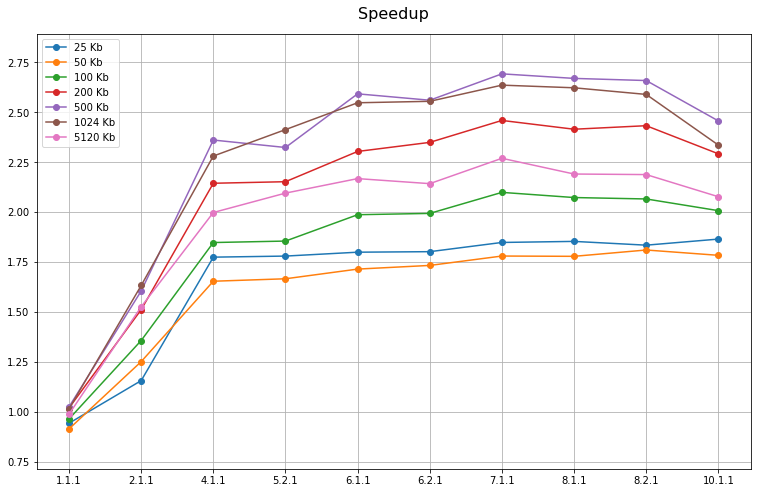

In [14]:
plot_line_chart("Speedup", speedup, chunk_sizes, thread_confs)

## Heat maps

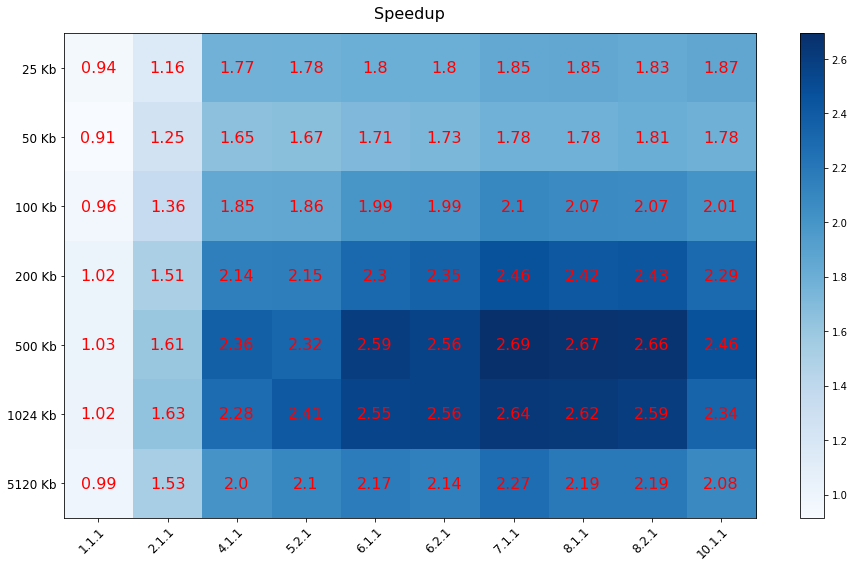

In [15]:
plot_heatmap('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Blues', 'red')

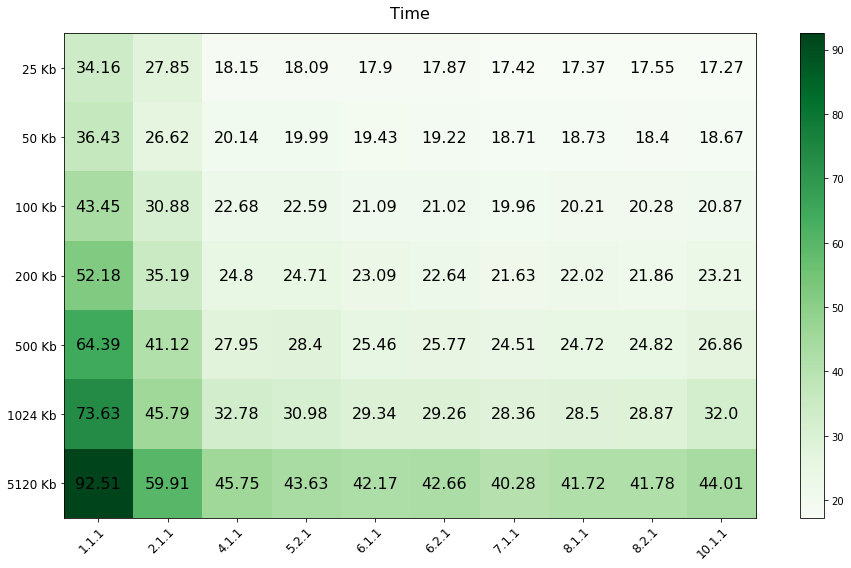

In [16]:
plot_heatmap('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Greens', 'black')

## 3D bar histograms 

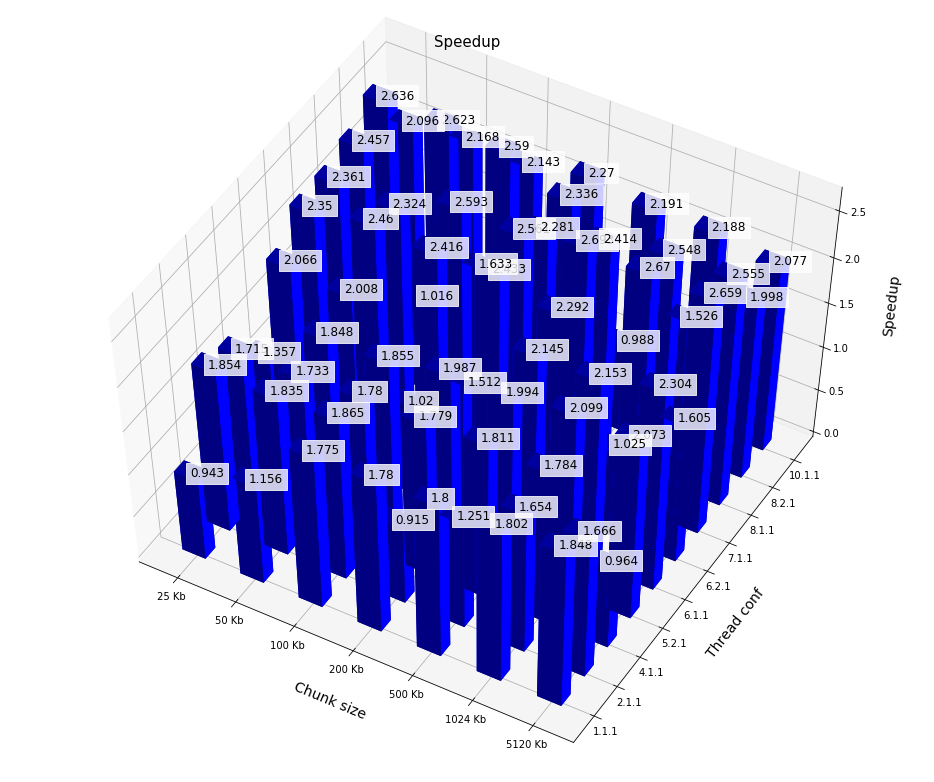

In [17]:
plot_3d_bar('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'b')

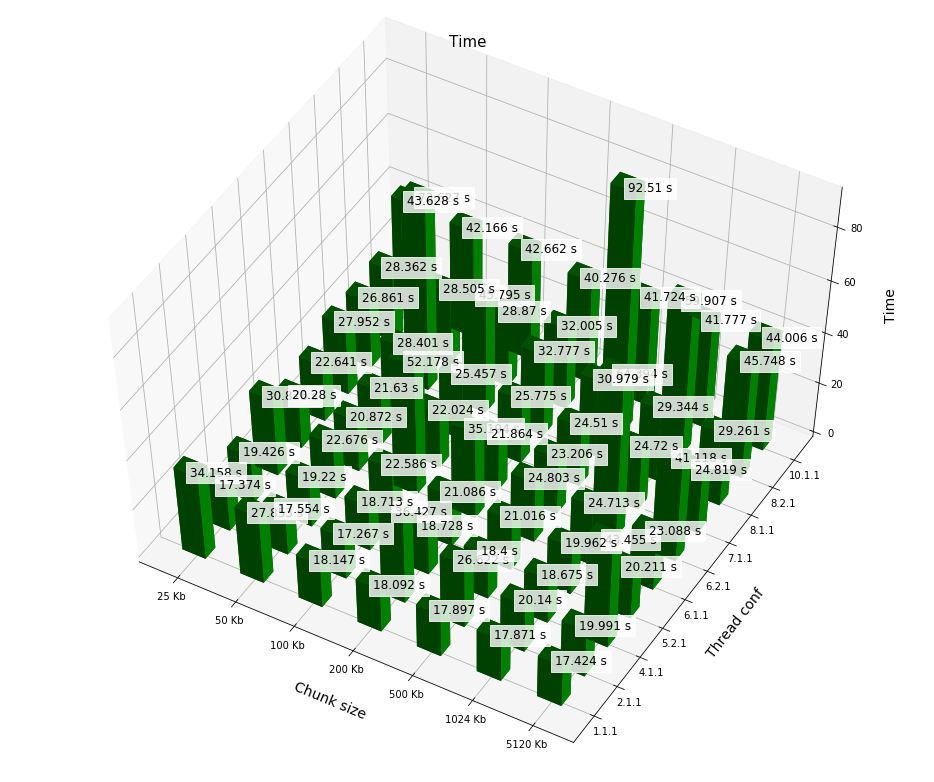

In [18]:
plot_3d_bar('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'g')